In [ ]:
%matplotlib inline


# Group Sparse inverse covariance for multi-subject connectome

This example shows how to estimate a connectome on a group of subjects
using the group sparse inverse covariance estimate.


In [1]:
import numpy as np

from nilearn import plotting

n_subjects = 4  # subjects to consider for group-sparse covariance (max: 40)


def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing. """

    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(cov, cmap=plotting.cm.bwr,
                         vmin=-1, vmax=1, title="%s / covariance" % title,
                         labels=labels)
    # Display precision matrix
    plotting.plot_matrix(prec, cmap=plotting.cm.bwr,
                         vmin=-span, vmax=span, title="%s / precision" % title,
                         labels=labels)

C:\Users\Jure\miniconda3\envs\fc\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Fetching datasets



In [2]:
from nilearn import datasets
msdl_atlas_dataset = datasets.fetch_atlas_msdl()
rest_dataset = datasets.fetch_development_fmri(n_subjects=n_subjects)

# print basic information on the dataset
print('First subject functional nifti image (4D) is at: %s' %
      rest_dataset.func[0])  # 4D data


Dataset created in C:\Users\Jure/nilearn_data\msdl_atlas



 ...done. (0 seconds, 0 min)
Extracting data from C:\Users\Jure/nilearn_data\msdl_atlas\01a216f54c9220cf2626a4d2eebe3981\MSDL_rois.zip..... done.
C:\Users\Jure\miniconda3\envs\fc\lib\site-packages\numpy\lib\npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)



Dataset created in C:\Users\Jure/nilearn_data\development_fmri


Dataset created in C:\Users\Jure/nilearn_data\development_fmri\development_fmri



 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 6045696 of 6136523 bytes (98.5%,    0.0s remaining) ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


First subject functional nifti image (4D) is at: C:\Users\Jure/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


 ...done. (3 seconds, 0 min)


## Extracting region signals



In [3]:
from nilearn import input_data

# A "memory" to avoid recomputation
from joblib import Memory
mem = Memory('nilearn_cache')

masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    high_variance_confounds=True, low_pass=None, high_pass=0.01,
    t_r=2, standardize=True, memory='nilearn_cache', memory_level=1,
    verbose=2)
masker.fit()

subject_time_series = []
func_filenames = rest_dataset.func
confound_filenames = rest_dataset.confounds
for func_filename, confound_filename in zip(func_filenames,
                                            confound_filenames):
    print("Processing file %s" % func_filename)

    region_ts = masker.transform(func_filename,
                                 confounds=confound_filename)
    subject_time_series.append(region_ts)

[NiftiMapsMasker.fit] loading regions from C:\Users\Jure\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
Processing file C:\Users\Jure/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


C:\Users\Jure\miniconda3\envs\fc\lib\site-packages\nilearn\image\image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


________________________________________________________________________________
[Memory] Calling nilearn.image.image.high_variance_confounds...
high_variance_confounds('C:\\Users\\Jure/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
__________________________________________high_variance_confounds - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('C:\\Users\\Jure/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': True,
  'low_pass': None,
  'maps_img': 'C:\\Users\\Jure/nilearn_data\\msdl_atlas\\MSDL_rois\\msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
 

## Computing group-sparse precision matrices



In [4]:
from nilearn.connectome import GroupSparseCovarianceCV
gsc = GroupSparseCovarianceCV(verbose=2)
gsc.fit(subject_time_series)

try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

gl = GraphicalLassoCV(verbose=2)
gl.fit(np.concatenate(subject_time_series))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 7
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 6
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 6
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 6
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 9
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 10
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 6
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 10
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 11
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.9s finished


[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  4 out of 4
[GroupSparseCovarianceCV.fit] Final optimization
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 19: 8.789e-04


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...

[GraphicalLassoCV] Done refinement  1 out of 4:   0s


.[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..

[GraphicalLassoCV] Done refinement  2 out of 4:   1s


..[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.

[GraphicalLassoCV] Done refinement  3 out of 4:   2s


...[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
..............

[GraphicalLassoCV] Done refinement  4 out of 4:   3s
[graphical_lasso] Iteration   0, cost  1.68e+02, dual gap 1.123e+00
[graphical_lasso] Iteration   1, cost  1.68e+02, dual gap -1.664e-03
[graphical_lasso] Iteration   2, cost  1.68e+02, dual gap 1.158e-04
[graphical_lasso] Iteration   3, cost  1.68e+02, dual gap 1.389e-04
[graphical_lasso] Iteration   4, cost  1.68e+02, dual gap 1.530e-04
[graphical_lasso] Iteration   5, cost  1.68e+02, dual gap 1.318e-04
[graphical_lasso] Iteration   6, cost  1.68e+02, dual gap 6.844e-05


..[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


GraphicalLassoCV(verbose=2)

## Displaying results



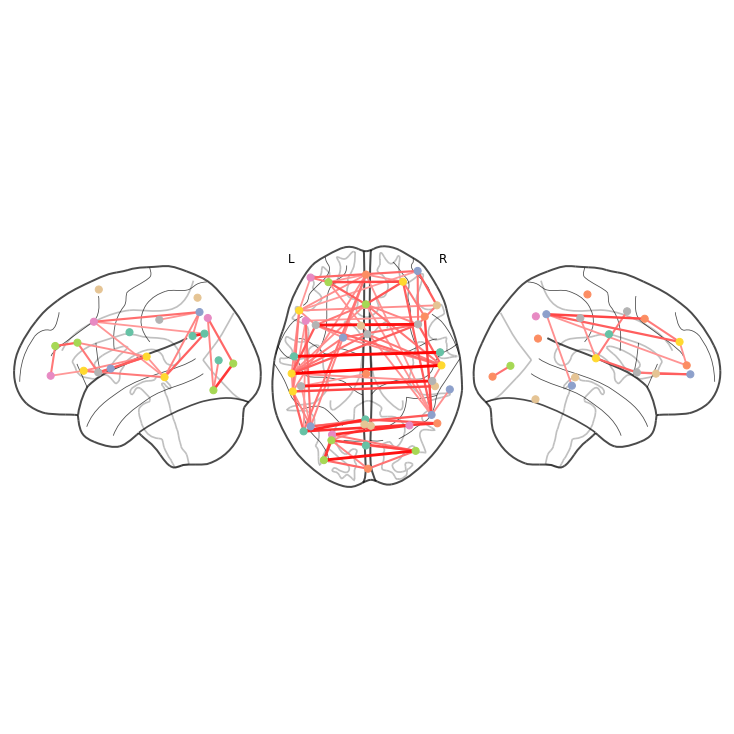

In [17]:
import matplotlib.pyplot as plt

atlas_img = msdl_atlas_dataset.maps
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = msdl_atlas_dataset.labels

f = plt.figure(figsize=(10,10))
plotting.plot_connectome(gl.covariance_,
                         atlas_region_coords, edge_threshold='90%',
                         #title="Covariance",
                         display_mode="lzr",
                         figure=f)

"""
plotting.plot_connectome(-gl.precision_, atlas_region_coords,
                         edge_threshold='90%',
                         title="Sparse inverse covariance (GraphicalLasso)",
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gl.covariance_, gl.precision_, "GraphicalLasso", labels)

title = "GroupSparseCovariance"
plotting.plot_connectome(-gsc.precisions_[..., 0],
                         atlas_region_coords, edge_threshold='90%',
                         title=title,
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gsc.covariances_[..., 0],
              gsc.precisions_[..., 0], title, labels)
"""

plotting.show()